In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import nibabel as nib
import matplotlib.pyplot as plt
# there was some problems for using import tensorflow as tf
# the way I found to fix it is the next two lines
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

import keras
import numpy as np
import os

from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, GlobalAveragePooling2D, Dense
from keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import to_categorical


In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        elif fullPath[-4:]=='.nii': # to avoid DS_Store or other system files
            allFiles.append(fullPath)
                
    return allFiles

In [5]:
def getImage( subject, directory ):

    epi_img = nib.load(directory + subject + '.nii')
    epi_img_data = epi_img.get_fdata()
        
    return epi_img_data

In [6]:
#extract m 5*5*5 patch from the images and put them in 'data' variable

#As we want to have 1000 patches from 100 MRI scanes
m = 100*10

#flatten patches
data = np.empty((m, 125))

#You may want to change the following line to the folder in which files are stores
directory = "./../../../../../Documents/Stanford/cs230/ADNI/ADNI_Clean/"
files = getListOfFiles(directory)
filenums = len(files)

# We will skip the patches that are all zero ('bad' patches)
num_added = 0

#for loop will continue until m 'good' patches added to data
for index in range(m):
    if num_added >= m:
        #all data is complete now
        break
    random = np.random.randint(filenums)
    filename = files[random]
    subject = filename[:-4]
    image = getImage(subject=subject, directory=directory)
    
    #about 10 patches from each image
    for i in range(10):
        n_i, n_j, n_k = image.shape
        rand = np.random.rand(3)
    
        corner_i = np.random.randint(n_i-5)
        corner_j = np.random.randint(n_j-5)
        corner_k = np.random.randint(n_k-5)
        patch = image[corner_i:corner_i+5,corner_j:corner_j+5,corner_k:corner_k+5]
        patch = patch.flatten()
        if np.linalg.norm(patch)!=0:
            data[num_added,:] = patch
#             print(data[index,:])
            num_added += 1
#             print('added', num_added)
            if num_added >= m:
                break
 
    
# Normalize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:int(0.7*m)])
X_train = np.transpose(scaler.fit_transform(data[:int(0.7*m)]))
X_test =  np.transpose(scaler.fit_transform(data[int(0.7*m):]))


Image Shape (256, 256, 166)
<class 'numpy.ndarray'>


In [30]:
#initializing parameters
n_inputs = 125
n_hidden = 150
n_outputs = 125

def initialize_parameters():
    
    
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [n_hidden,n_inputs])
    b1 = tf.get_variable("b1",[n_hidden,1],initializer=tf.zeros_initializer())
    b2 = tf.get_variable("b2",[n_outputs,1],initializer=tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "b2": b2}
    
    return parameters

In [39]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()

In [40]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


#retrive parameters
W1 = parameters['W1']
b1 = parameters['b1']
b2 = parameters['b2']


learning_rate = 0.01

#sparsity hyper-parameter (It is not the best amount)
s=0.05

#penalty for sparsity (It is not the best amount)
beta = 1

#lambda, hyperparameter for weights (It is not the best amount)
lamb = 1

# Define architecture of autoencoder
X = tf.placeholder(tf.float32, shape=[n_inputs, None])
Z1 = tf.add(tf.matmul(W1,X),b1)

#regarding the paper first layer activation is sigmoid
hidden = tf.nn.sigmoid(Z1)

#regarding the paper second activation is identity
#regarding the paper the kernel for second activation is transpose of the first layer kernel
outputs = tf.add(tf.matmul(tf.transpose(W1),hidden),b2) 

# calculating kullback leibler loss
Shat = tf.reduce_mean(hidden,axis=0)
KL1 = s*(tf.log(s)-tf.log(Shat))+(1-s)*(tf.log(1-s)-tf.log(1-Shat))
KL = tf.math.reduce_sum(KL1)

#calculating norm loss
weight_L2_norm = tf.reduce_mean(tf.square(W1))

#calculating similarity loss
similoss = tf.reduce_mean(tf.square(outputs - X))/2

# Define loss function and optimizer
loss = tf.reduce_mean(tf.square(outputs - X))/2 + beta*KL + lamb*weight_L2_norm

#defining optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

#initialization
init = tf.global_variables_initializer()

n_iterations = 1000

costs = []
test_costs = []
random_costs = []

print('type xtrain', type(X_train))


type xtrain <class 'numpy.ndarray'>


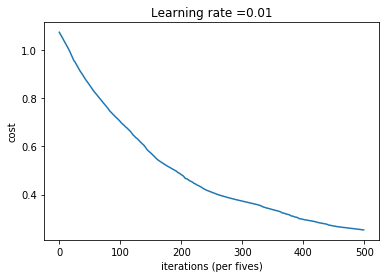

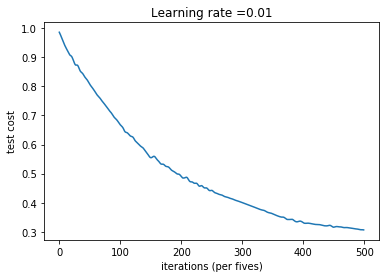

test_loss 0.30655682


In [41]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        _ , cost = sess.run([training_op,loss],feed_dict={X:X_train})
        
        costs.append(cost)
#         training_op.run(feed_dict={X: X_train})
        
            
#         train_loss=loss.eval(feed_dict={X:X_train})
#         print(train_loss)
    
    
        test_loss=loss.eval(feed_dict={X:X_test})
        test_costs.append(test_loss)
        
#         random_loss = loss.eval(feed_dict={X:np.random.randn(30,125)})
#         random_costs.append(random_loss)

    
    
#     test_output = outputs.eval(feed_dict={X:X_test})
    
    
    # plot the cost
    plt.plot(np.squeeze(costs[500:]))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # plot the test cost
    plt.plot(np.squeeze(test_costs[500:]))
    plt.ylabel('test cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
#     # plot the test cost
#     plt.plot(np.squeeze(random_costs))
#     plt.ylabel('test cost')
#     plt.xlabel('iterations (per fives)')
#     plt.title("Learning rate =" + str(learning_rate))
#     plt.show()
    
#     print(X_test.shape,'X_test shape')
#     print(test_output.shape,'test output shape')
#     print(tf.square(outputs - X).shape,'shape of tf.square')
#     print('tf.square',tf.square(outputs - X).eval(feed_dict={X:X_test}))
#     print('equal',(test_output-X_test)*(test_output-X_test))
#     print(tf.reduce_mean(tf.square(outputs - X)).shape,'reduce mean shape')
    
    final_test_loss=loss.eval(feed_dict={X:X_test})
    
    print('test_loss',final_test_loss)
#     print()


    # lets save the parameters in a variable, we may need trained parameters to use for the next part of DL
    parameters = sess.run(parameters)